Engie Project

Last Update: June 15, 2021

Notes: Added Diesel as an option

Run Time:3 minutes 

In [1]:
### Initialize
import DataFrames, CSV, Plots, JuMP, Gurobi

In [2]:
##Reading in Data
using CSV, DataFrames
Data = CSV.read("Data.csv", DataFrame, normalizenames=true)


,hour,heating_kW_th_h_m2_,PV_electricity_kW,Wind_electricity_kW,Demand_kW
,Float64?,Float64?,Float64?,Float64?,Float64?
1,1.0,0.0,0.0,0.0839,1664.74
2,2.0,0.0001,0.0,0.0839,1551.21
3,3.0,0.0,0.0,0.0839,1429.02
4,4.0,0.0012,0.0,0.0839,1350.95
5,5.0,0.0081,0.0,0.0839,1324.06
6,6.0,0.009,0.0,0.0839,1296.71
7,7.0,0.0139,0.0,0.0839,1597.59
8,8.0,0.0194,0.0,0.1533,1479.02
9,9.0,0.0171,0.0,0.1533,1791.12


In [3]:
##Saving Columns as their variables
ElecDemand = Data[1:8760,5] #kW
ElecDemand = identity.(ElecDemand)

PV = Data[1:8760,3] #kW
PV = identity.(PV)

Cost_Elec = Data[1:8760,6] #
Cost_Elec = identity.(Cost_Elec)

Cost_Diesel = Data[1:8760,7] #
Cost_Diesel = identity.(Cost_Diesel)

8760-element Array{Float64,1}:
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 ⋮
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119
 0.119

Long Term Variables (Investment Variables) :
E_Rated = Battery Rated Capacity
P_Rated = Battery Rated Power

Binary 1: Invest in Battery

Binary 2: Invest in Diesel Genset


Short Term Variables (Operational Variables):
EState_Batt = Battery State of Charge at Time t
PState_Batt = Battery Power at Time t
P_Grid = Power Consumed/ Injected to the grid

Parameters

Cost_BattE = Investment Cost of Battery, energy component

Cost_BattP = Investment cost of battery, power 

Cost_OM= Fixed yearly operation and maintenance costs

DiscountRate = discount rate, werighted average cost of capital

Cost_Electricity = Price of Electricity (optional binary)


In [4]:
using JuMP, Gurobi

model = Model(Gurobi.Optimizer)
## Short Term Variables
@variable(model,P_Batt[1:8760],container=Array)
@variable(model,P_Grid[1:8760],container=Array)
@variable(model,UseBattery,binary=true)
@variable(model,UseDiesel, binary=true)

@variable(model, P_Sell[1:8760], container=Array)
@variable(model, P_Buy[1:8760], container=Array)
@variable(model, P_Diesel[1:8760], container=Array)
@variable(model, mu[1:8760], binary=true)
@variable(model,E_Batt[1:8760],container=Array)

##long term variables
@variable(model, E_Rated)
@variable(model,P_Rated)
@variable(model, P_Rated_Diesel)


Academic license - for non-commercial use only - expires 2021-08-04


P_Rated_Diesel

In [ ]:
##Carbon Tax
Liters = 0.4 ## L / kWh
kg = 2.6 ## kg Co2/ L
TonsCO2 = Liters*kg/1000 
Tax = 60*TonsCO2 ##EUR 60 per tonne of CO2 mid range bench mark 2020 for OECD

In [5]:
##Battery Investment Costs
CostEnergy = 300 ##euros/kWh
CostPower = 300 ##euros/kW
BIVC = E_Rated*CostEnergy + P_Rated*CostPower

##Diesel Investment Costs
CostDieselPower =400  ##€/kW
DIVC = P_Rated_Diesel * CostDieselPower

400 P_Rated_Diesel

In [6]:
## Present Value of O&M Costs Battery
CostOMLiIon = 20.5 ## Eurp/kWh/Yr
#Investment Horizon
Y= 3
Discount_Rate = .0025
OMCLiIon=0
for y in Y
    OMCLiIon = OMCLiIon+(E_Rated*CostOMLiIon)/(1+Discount_Rate)^y
end

## Present Value of O&M Costs Diesel
CostOMDiesel = 20 # €/kW/yr
Discount_Rate = .0025
OMCDiesel=0
for y in Y
    OMCDiesel = OMCDiesel+(P_Rated_Diesel*CostOMDiesel)/(1+Discount_Rate)^y
end

In [7]:
##Residual Value of Battery at end of investment horizon
DepreciationTime = 10 # Years, from excel sheet
ResidValBatt = (1-Y/DepreciationTime)*BIVC
##Residual Value of Diesel Genset at end of investment horizon
ResidValDiesel = (1-Y/DepreciationTime)*DIVC

280 P_Rated_Diesel

In [8]:
##GRID
SellingPrice = 0.3 ##Edit this as needed
BuySellTotalCost=0
for y in Y
    BuySellCost = P_Buy.* Cost_Elec +P_Sell.*Cost_Elec*SellingPrice
    BuySellTotalCost = BuySellTotalCost + sum(BuySellCost)/(1+Discount_Rate)^y
end

##DIESEL
DBuyTotalCost=0
for y in Y
    DBuyCost = P_Diesel.* Cost_Diesel
    DBuyTotalCost = DBuyTotalCost + sum(DBuyCost)/(1+Discount_Rate)^y
end


In [9]:
## 0 if not used, *1 if used
OpMainCosts = UseBattery*OMCLiIon + UseDiesel*OMCDiesel
InvestmentCosts = UseBattery*BIVC + UseDiesel*DIVC
ResidualValue = UseBattery*ResidValBatt + UseDiesel*ResidValDiesel
BuyingSelling = UseBattery*BuySellTotalCost + UseDiesel*DBuyTotalCost

TotalCost = BuyingSelling + OpMainCosts + InvestmentCosts - ResidualValue

@objective(model, Min, TotalCost)

0.06838582302460529 UseBattery*P_Buy[1] + 0.020515746907381584 UseBattery*P_Sell[1] + 0.0645149273817031 UseBattery*P_Buy[2] + 0.019354478214510928 UseBattery*P_Sell[2] + 0.05985000186333379 UseBattery*P_Buy[3] + 0.017955000559000137 UseBattery*P_Sell[3] + 0.04962686721669469 UseBattery*P_Buy[4] + 0.014888060165008406 UseBattery*P_Sell[4] + 0.04734403132472673 UseBattery*P_Buy[5] + 0.01420320939741802 UseBattery*P_Sell[5] + 0.0476417925280269 UseBattery*P_Buy[6] + 0.01429253775840807 UseBattery*P_Sell[6] + 0.04942835974782791 UseBattery*P_Buy[7] + 0.014828507924348372 UseBattery*P_Sell[7] + 0.05468880767279755 UseBattery*P_Buy[8] + 0.016406642301839264 UseBattery*P_Sell[8] + 0.04446567302615844 UseBattery*P_Buy[9] + 0.01333970190784753 UseBattery*P_Sell[9] + 0.04922985227896113 UseBattery*P_Buy[10] + 0.014768955683688339 UseBattery*P_Sell[10] + 0.054986568876097715 UseBattery*P_Buy[11] + 0.016495970662829314 UseBattery*P_Sell[11] + 0.062132837755301755 UseBattery*P_Buy[12] + 0.01863985

Power Balance Constraints

In [10]:
##Power Balance
@constraint(model,[i = 1:8760],ElecDemand[i]==PV[i]+P_Batt[i]+P_Grid[i]+P_Diesel[i])
 # + if pulling from supply, ex P_Batt = +5 means taking 5kW from battery -5 would be saving 5kw

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 -P_Batt[1] - P_Grid[1] - P_Diesel[1] == -1664.7351
 -P_Batt[2] - P_Grid[2] - P_Diesel[2] == -1551.2123
 -P_Batt[3] - P_Grid[3] - P_Diesel[3] == -1429.0156
 -P_Batt[4] - P_Grid[4] - P_Diesel[4] == -1350.9513
 -P_Batt[5] - P_Grid[5] - P_Diesel[5] == -1324.0599
 -P_Batt[6] - P_Grid[6] - P_Diesel[6] == -1296.7088
 -P_Batt[7] - P_Grid[7] - P_Diesel[7] == -1597.5924
 -P_Batt[8] - P_Grid[8] - P_Diesel[8] == -1479.0196
 -P_Batt[9] - P_Grid[9] - P_Diesel[9] == -1791.1166
 -P_Batt[10] - P_Grid[10] - P_Diesel[10] == -1686.4823000000001
 -P_Batt[11] - P_Grid[11] - P_Diesel[11] == -1478.9926
 -P_Batt[12] - P_Grid[12] - P_Diesel[12] == -1503.395
 -P_Batt[13] - P_Grid[13] - P_Diesel[13] == -1323.988
 ⋮
 -P_Batt[8749] - P_Grid[8749] - P_Diesel[8749] == -3316.7787999999996
 -P_Batt[8750] - P_Grid[8750] - P_Diesel[8750] == -3486.9209


Battery Constraints

In [11]:
##Start with a full battery
@constraint((model),E_Batt[1] == E_Rated)


E_Batt[1] - E_Rated == 0.0

In [12]:
## 1 Rated power must be between the min and max
P_Max = 100000 ##kW from excel
P_Min = 600 ##kW from excel
@constraint(model, P_Min <= P_Rated <= P_Max)

P_Rated in [600.0, 100000.0]

In [13]:
## 2 Energy Constraints based on EP ratio
MaxEPRatio=10 ## Ratio from Excel
MinEPRatio=0.25 ##Ratio from Excel
@constraint(model, (P_Min * MinEPRatio)<= E_Rated <= (P_Max*MaxEPRatio))

E_Rated in [150.0, 1.0e6]

In [14]:
## 3 Battery power at time t cannot exceed Rated Power
@constraint(model, [ i=1:8760], P_Batt[i].<= P_Rated)
@constraint(model, [ i=1:8760], P_Batt[i].>= -P_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.GreaterThan{Float64}},ScalarShape},1}:
 P_Batt[1] + P_Rated >= 0.0
 P_Batt[2] + P_Rated >= 0.0
 P_Batt[3] + P_Rated >= 0.0
 P_Batt[4] + P_Rated >= 0.0
 P_Batt[5] + P_Rated >= 0.0
 P_Batt[6] + P_Rated >= 0.0
 P_Batt[7] + P_Rated >= 0.0
 P_Batt[8] + P_Rated >= 0.0
 P_Batt[9] + P_Rated >= 0.0
 P_Batt[10] + P_Rated >= 0.0
 P_Batt[11] + P_Rated >= 0.0
 P_Batt[12] + P_Rated >= 0.0
 P_Batt[13] + P_Rated >= 0.0
 ⋮
 P_Batt[8749] + P_Rated >= 0.0
 P_Batt[8750] + P_Rated >= 0.0
 P_Batt[8751] + P_Rated >= 0.0
 P_Batt[8752] + P_Rated >= 0.0
 P_Batt[8753] + P_Rated >= 0.0
 P_Batt[8754] + P_Rated >= 0.0
 P_Batt[8755] + P_Rated >= 0.0
 P_Batt[8756] + P_Rated >= 0.0
 P_Batt[8757] + P_Rated >= 0.0
 P_Batt[8758] + P_Rated >= 0.0
 P_Batt[8759] + P_Rated >= 0.0
 P_Batt[8760] + P_Rated >= 0.0

In [15]:
## Battery State of Charge Updating with RT Eff and Dissipation Rate
RTEff = 0.90  ## from excel
DissipationRt = 0.00004 ## from excel

@constraint(model, [ i=2:8760], E_Batt[i] == (1-DissipationRt)*E_Batt[i-1]+P_Grid[i-1]*sqrt(RTEff)+P_Diesel[i-1]*sqrt(RTEff) ) ##zacharies is -P, so check this

1-dimensional DenseAxisArray{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1,...} with index sets:
    Dimension 1, 2:8760
And data, a 8759-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.EqualTo{Float64}},ScalarShape},1}:
 -0.9486832980505138 P_Grid[1] - 0.9486832980505138 P_Diesel[1] - 0.99996 E_Batt[1] + E_Batt[2] == 0.0
 -0.9486832980505138 P_Grid[2] - 0.9486832980505138 P_Diesel[2] - 0.99996 E_Batt[2] + E_Batt[3] == 0.0
 -0.9486832980505138 P_Grid[3] - 0.9486832980505138 P_Diesel[3] - 0.99996 E_Batt[3] + E_Batt[4] == 0.0
 -0.9486832980505138 P_Grid[4] - 0.9486832980505138 P_Diesel[4] - 0.99996 E_Batt[4] + E_Batt[5] == 0.0
 -0.9486832980505138 P_Grid[5] - 0.9486832980505138 P_Diesel[5] - 0.99996 E_Batt[5] + E_Batt[6] == 0.0
 -0.9486832980505138 P_Grid[6] - 0.9486832980505138 P_Diesel[6] - 0.99996 E_B

In [16]:
## Charging/discharging power constraints
@constraint(model, [i=1:8760], P_Batt[i] <= P_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Batt[1] - P_Rated <= 0.0
 P_Batt[2] - P_Rated <= 0.0
 P_Batt[3] - P_Rated <= 0.0
 P_Batt[4] - P_Rated <= 0.0
 P_Batt[5] - P_Rated <= 0.0
 P_Batt[6] - P_Rated <= 0.0
 P_Batt[7] - P_Rated <= 0.0
 P_Batt[8] - P_Rated <= 0.0
 P_Batt[9] - P_Rated <= 0.0
 P_Batt[10] - P_Rated <= 0.0
 P_Batt[11] - P_Rated <= 0.0
 P_Batt[12] - P_Rated <= 0.0
 P_Batt[13] - P_Rated <= 0.0
 ⋮
 P_Batt[8749] - P_Rated <= 0.0
 P_Batt[8750] - P_Rated <= 0.0
 P_Batt[8751] - P_Rated <= 0.0
 P_Batt[8752] - P_Rated <= 0.0
 P_Batt[8753] - P_Rated <= 0.0
 P_Batt[8754] - P_Rated <= 0.0
 P_Batt[8755] - P_Rated <= 0.0
 P_Batt[8756] - P_Rated <= 0.0
 P_Batt[8757] - P_Rated <= 0.0
 P_Batt[8758] - P_Rated <= 0.0
 P_Batt[8759] - P_Rated <= 0.0
 P_Batt[8760] - P_Rated <= 0.0

In [17]:
## 5 Energy constraints with depth of discharge
DOD = 0.9
@constraint(model, [i=1:8760], (1-DOD)*E_Rated <= E_Batt[i])
@constraint(model, [i=1:8760],  E_Batt[i] <= E_Rated)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 E_Batt[1] - E_Rated <= 0.0
 E_Batt[2] - E_Rated <= 0.0
 E_Batt[3] - E_Rated <= 0.0
 E_Batt[4] - E_Rated <= 0.0
 E_Batt[5] - E_Rated <= 0.0
 E_Batt[6] - E_Rated <= 0.0
 E_Batt[7] - E_Rated <= 0.0
 E_Batt[8] - E_Rated <= 0.0
 E_Batt[9] - E_Rated <= 0.0
 E_Batt[10] - E_Rated <= 0.0
 E_Batt[11] - E_Rated <= 0.0
 E_Batt[12] - E_Rated <= 0.0
 E_Batt[13] - E_Rated <= 0.0
 ⋮
 E_Batt[8749] - E_Rated <= 0.0
 E_Batt[8750] - E_Rated <= 0.0
 E_Batt[8751] - E_Rated <= 0.0
 E_Batt[8752] - E_Rated <= 0.0
 E_Batt[8753] - E_Rated <= 0.0
 E_Batt[8754] - E_Rated <= 0.0
 E_Batt[8755] - E_Rated <= 0.0
 E_Batt[8756] - E_Rated <= 0.0
 E_Batt[8757] - E_Rated <= 0.0
 E_Batt[8758] - E_Rated <= 0.0
 E_Batt[8759] - E_Rated <= 0.0
 E_Batt[8760] - E_Rated <= 0.0

Grid Constraints -- Until 2024

In [18]:
## 6 Grid can only provide 2MW = 2000 kW until 2024
@constraint(model, [i=1:8760],-2000 <= P_Grid[i])
@constraint(model, [i=1:8760],P_Grid[i] <= 2000)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Grid[1] <= 2000.0
 P_Grid[2] <= 2000.0
 P_Grid[3] <= 2000.0
 P_Grid[4] <= 2000.0
 P_Grid[5] <= 2000.0
 P_Grid[6] <= 2000.0
 P_Grid[7] <= 2000.0
 P_Grid[8] <= 2000.0
 P_Grid[9] <= 2000.0
 P_Grid[10] <= 2000.0
 P_Grid[11] <= 2000.0
 P_Grid[12] <= 2000.0
 P_Grid[13] <= 2000.0
 ⋮
 P_Grid[8749] <= 2000.0
 P_Grid[8750] <= 2000.0
 P_Grid[8751] <= 2000.0
 P_Grid[8752] <= 2000.0
 P_Grid[8753] <= 2000.0
 P_Grid[8754] <= 2000.0
 P_Grid[8755] <= 2000.0
 P_Grid[8756] <= 2000.0
 P_Grid[8757] <= 2000.0
 P_Grid[8758] <= 2000.0
 P_Grid[8759] <= 2000.0
 P_Grid[8760] <= 2000.0

In [19]:
@constraint(model, [i=1:8760], P_Diesel[i] <= P_Rated_Diesel)

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Diesel[1] - P_Rated_Diesel <= 0.0
 P_Diesel[2] - P_Rated_Diesel <= 0.0
 P_Diesel[3] - P_Rated_Diesel <= 0.0
 P_Diesel[4] - P_Rated_Diesel <= 0.0
 P_Diesel[5] - P_Rated_Diesel <= 0.0
 P_Diesel[6] - P_Rated_Diesel <= 0.0
 P_Diesel[7] - P_Rated_Diesel <= 0.0
 P_Diesel[8] - P_Rated_Diesel <= 0.0
 P_Diesel[9] - P_Rated_Diesel <= 0.0
 P_Diesel[10] - P_Rated_Diesel <= 0.0
 P_Diesel[11] - P_Rated_Diesel <= 0.0
 P_Diesel[12] - P_Rated_Diesel <= 0.0
 P_Diesel[13] - P_Rated_Diesel <= 0.0
 ⋮
 P_Diesel[8749] - P_Rated_Diesel <= 0.0
 P_Diesel[8750] - P_Rated_Diesel <= 0.0
 P_Diesel[8751] - P_Rated_Diesel <= 0.0
 P_Diesel[8752] - P_Rated_Diesel <= 0.0
 P_Diesel[8753] - P_Rated_Diesel <= 0.0
 P_Diesel[8754] - P_Rated_Diesel <= 0.0
 P_Diesel[8755] - P_Rated_Diesel <= 0.0
 P_Diesel[8756] - P_Rated_Diesel <= 0.0
 P_Diesel[8757] - P_

In [20]:
##Energy drawn cannot exceed what's in the battery
@constraint(model, [ i=2:8760], P_Batt[i] <= E_Batt[i-1]) ##check indexing

1-dimensional DenseAxisArray{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1,...} with index sets:
    Dimension 1, 2:8760
And data, a 8759-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Batt[2] - E_Batt[1] <= 0.0
 P_Batt[3] - E_Batt[2] <= 0.0
 P_Batt[4] - E_Batt[3] <= 0.0
 P_Batt[5] - E_Batt[4] <= 0.0
 P_Batt[6] - E_Batt[5] <= 0.0
 P_Batt[7] - E_Batt[6] <= 0.0
 P_Batt[8] - E_Batt[7] <= 0.0
 P_Batt[9] - E_Batt[8] <= 0.0
 P_Batt[10] - E_Batt[9] <= 0.0
 P_Batt[11] - E_Batt[10] <= 0.0
 P_Batt[12] - E_Batt[11] <= 0.0
 P_Batt[13] - E_Batt[12] <= 0.0
 P_Batt[14] - E_Batt[13] <= 0.0
 ⋮
 P_Batt[8749] - E_Batt[8748] <= 0.0
 P_Batt[8750] - E_Batt[8749] <= 0.0
 P_Batt[8751] - E_Batt[8750] <= 0.0
 P_Batt[8752] - E_Batt[8751] <= 0.0
 P_Batt[8753] - E_Batt[8752] <= 0.0
 P_Batt[

In [21]:
## Binary, for buying and selling
@constraint(model, [i=1:8760], P_Grid[i]==P_Sell[i]+P_Buy[i]) ##either selling or buying
##Ex. Selling = -5 kw cannot exceed -2000kW
@constraint(model, [i=1:8760], -2000*mu[i] <= P_Sell[i])
@constraint(model, [i=1:8760], P_Sell[i] <= 0)
@constraint(model, [i=1:8760], 0 <= P_Buy[i])
@constraint(model, [i=1:8760], P_Buy[i] <= 2000*(1-mu[i]))

8760-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.LessThan{Float64}},ScalarShape},1}:
 P_Buy[1] + 2000 mu[1] <= 2000.0
 P_Buy[2] + 2000 mu[2] <= 2000.0
 P_Buy[3] + 2000 mu[3] <= 2000.0
 P_Buy[4] + 2000 mu[4] <= 2000.0
 P_Buy[5] + 2000 mu[5] <= 2000.0
 P_Buy[6] + 2000 mu[6] <= 2000.0
 P_Buy[7] + 2000 mu[7] <= 2000.0
 P_Buy[8] + 2000 mu[8] <= 2000.0
 P_Buy[9] + 2000 mu[9] <= 2000.0
 P_Buy[10] + 2000 mu[10] <= 2000.0
 P_Buy[11] + 2000 mu[11] <= 2000.0
 P_Buy[12] + 2000 mu[12] <= 2000.0
 P_Buy[13] + 2000 mu[13] <= 2000.0
 ⋮
 P_Buy[8749] + 2000 mu[8749] <= 2000.0
 P_Buy[8750] + 2000 mu[8750] <= 2000.0
 P_Buy[8751] + 2000 mu[8751] <= 2000.0
 P_Buy[8752] + 2000 mu[8752] <= 2000.0
 P_Buy[8753] + 2000 mu[8753] <= 2000.0
 P_Buy[8754] + 2000 mu[8754] <= 2000.0
 P_Buy[8755] + 2000 mu[8755] <= 2000.0
 P_Buy[8756] + 2000 mu[8756] <= 2000.0
 P_Buy[8757] + 2000 mu[8757] <= 2000.0
 P_Buy[8758] + 2000 mu[8758] <= 2000.

In [22]:
optimize!(model)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 140161 rows, 61327 columns and 280320 nonzeros
Model fingerprint: 0xc23ba743
Model has 26275 quadratic objective terms
Variable types: 52565 continuous, 8762 integer (8762 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-05, 3e+02]
  Bounds range     [2e+02, 1e+06]
  RHS range        [7e+02, 4e+03]
Presolve removed 52567 rows and 8765 columns
Presolve time: 1.06s
Presolved: 113876 rows, 78839 columns, 280305 nonzeros
Presolved model has 2 SOS constraint(s)
Variable types: 70076 continuous, 8763 integer (8763 binary)
Found heuristic solution: objective 0.0000000

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34513   -6.3625875e+07   

In [23]:
value(P_Rated) ##kW

100000.0

In [35]:
value(UseBattery)

0.0

In [36]:
value(UseDiesel)

1.0

In [32]:
value(P_Rated_Diesel)

-1995.7836297864415

In [33]:
value(E_Rated)##kWh

1.0e6

In [34]:
value(TotalCost)/1e6 ## Million Euros

-2.467723253542657

In [27]:
E_Batt_Optimized = JuMP.value.(E_Batt)
P_Batt_Optimized = JuMP.value.(P_Batt)
P_Grid_Optimized = JuMP.value.(P_Grid)
P_Diesel_Optimized = JuMP.value.(P_Diesel)
P_Buy_Optimized = JuMP.value.(P_Buy)
P_Sell_Optimized = JuMP.value.(P_Sell)

8760-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

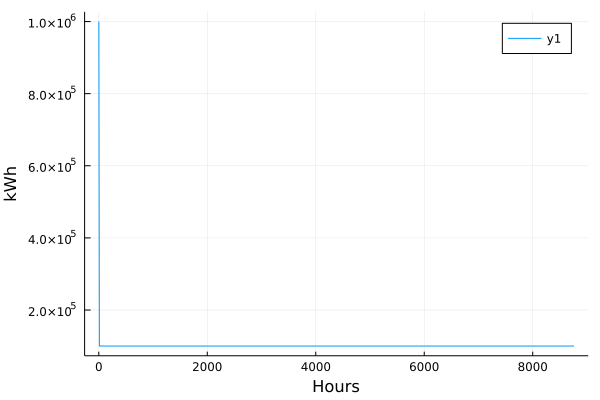

In [28]:
##Battery State of Charge 
using Plots
x = 1:8760
plot(x,E_Batt_Optimized)
xlabel!("Hours")
ylabel!("kWh")


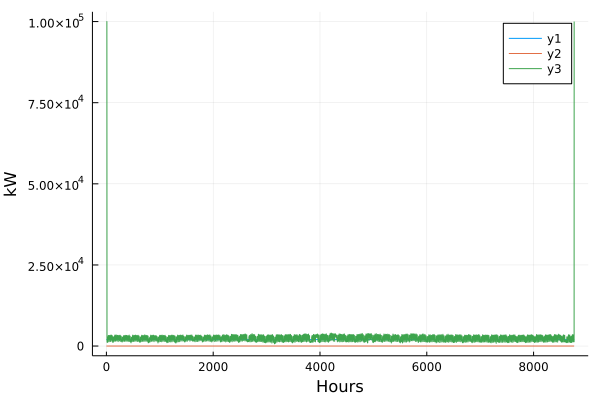

In [29]:
using Plots

plot(x, P_Buy_Optimized)
plot!(x,P_Sell_Optimized)
plot!(x,P_Batt_Optimized)
xlabel!("Hours")
ylabel!("kW")



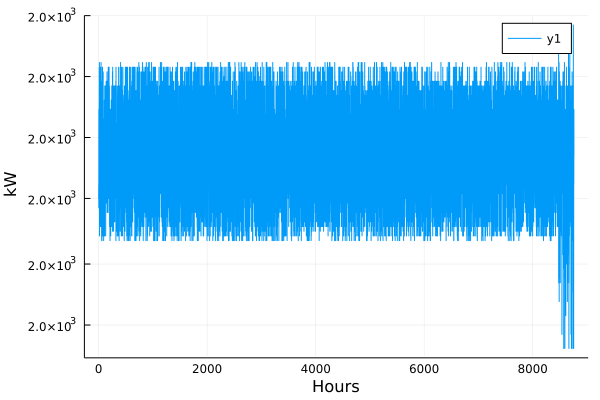

GKS: Possible loss of precision in routine SET_WINDOW


In [30]:
plot(x, P_Grid_Optimized)
xlabel!("Hours")
ylabel!("kW")

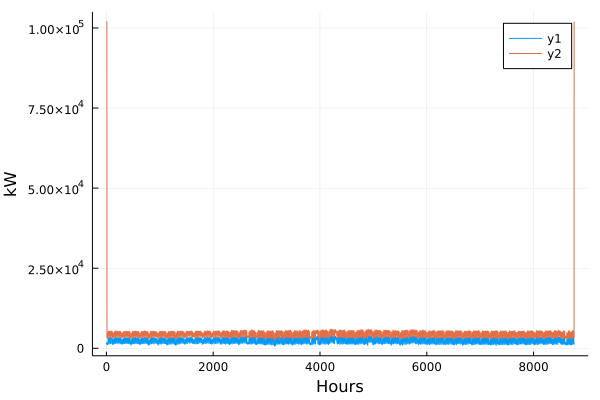

In [31]:
##checking that demand is met
plot(x, ElecDemand)
check = P_Grid_Optimized + P_Batt_Optimized + PV
plot!(x,check)
xlabel!("Hours")
ylabel!("kW")